In [17]:
import numpy as np
import mynn as nn
from dataset.mnist_load import *
import pickle

np.random.seed(309)
train_images = load_images('dataset/train-images-idx3-ubyte')
train_labels = load_labels('dataset/train-labels-idx1-ubyte')
print(f"Training data shape: {train_images.shape}")
test_images = load_images('dataset/t10k-images-idx3-ubyte')
test_labels = load_labels('dataset/t10k-labels-idx1-ubyte')
print(f"Test data shape: {test_images.shape}")

magic, num_imgs, rows, cols: 2051 60000 28 28
magic, num_labels: 2049 60000
Training data shape: (60000, 28, 28)
magic, num_imgs, rows, cols: 2051 10000 28 28
magic, num_labels: 2049 10000
Test data shape: (10000, 28, 28)


In [18]:
# reshape and normalize from [0, 255] to [0, 1]
train_images = train_images.reshape(-1, 784) / 255.0
test_images = test_images.reshape(-1, 784) / 255.0
train_labels = train_labels
test_labels = test_labels
print(f"Training data shape: {train_images.shape}")
print(f"Test data shape: {test_images.shape}")

Training data shape: (60000, 784)
Test data shape: (10000, 784)


In [19]:
# choose 10000 samples from train set as validation set.
val_size = 10000
indices = np.random.permutation(len(train_images))
train_indices = indices[val_size:]
val_indices = indices[:val_size]

train_images, val_images = train_images[train_indices], train_images[val_indices]
train_labels, val_labels = train_labels[train_indices], train_labels[val_indices]


print(f"Training data shape: {train_images.shape}")
print(f"Validation data shape: {val_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Training data shape: (50000, 784)
Validation data shape: (10000, 784)
Training labels shape: (50000,)
Validation labels shape: (10000,)


In [20]:
# Train
model = nn.Model(module = nn.module.MLP([784, 600, 10], nn.op.Sigmoid(), [1e-4, 1e-4]),
                optimizer = nn.optimizer.SGD(init_lr=0.06),
                scheduler = nn.lr_scheduler.MultiStepLR(milestones=[800, 2400, 4000], gamma=0.5),
                loss_fn = 'CrossEntropyLoss'
                )

epochs = 10000
bsz = 4096
patience = 500 
counter = 0

X = train_images
y = train_labels
val_X = val_images
val_y = val_labels

train_loss = []
train_score = []
eval_score_ls = []

save_path = "saved_models/best_model.pickle"
best_score = 0.0
best_epoch = None
    
for epoch in range(epochs):
    
    indices = np.random.permutation(X.shape[0])
    X = X[indices]
    y = y[indices]    
    
    model.train()
    running_loss = 0.0
    running_score = 0.0
    
    for it in range(int(X.shape[0] / bsz) + 1):
        
        train_X = X[it * bsz : (it+1) * bsz]
        train_y = y[it * bsz : (it+1) * bsz]

        model.zero_grad()
        output = model(train_X)
        
        loss = model.loss_fn(output, train_y)
        running_loss += loss
        
        model.backward(output, train_y)
        model.optimizerStep()
        model.schedulerStep()
    
    train_loss.append(running_loss)
    
    model.eval()
    score = nn.metric.accuracy(model(X), y)
    train_score.append(score)
        
    y_pred = model(val_X)
    eval_score = nn.metric.accuracy(y_pred, val_y)  
    eval_score_ls.append(eval_score) 
    
    if best_score < eval_score:
        model.save_model(save_path)
        best_epoch = epoch
        best_score = eval_score
        counter = 0
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.5f}, Accuracy: {score * 100:.2f}%, Eval Accuracy: {eval_score * 100:.2f}%, Update best model")
    else:
        counter += 1
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.5f}, Accuracy: {score * 100:.2f}%, Eval Accuracy: {eval_score * 100:.2f}%, patience {counter}")
    
    if counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break
    
print(f"Final update of best model: Epoch {best_epoch}, Accuracy {best_score}.")

Epoch 1/10000, Loss: 25.52068, Accuracy: 68.78%, Eval Accuracy: 69.88%, Update best model
Epoch 2/10000, Loss: 16.55939, Accuracy: 77.07%, Eval Accuracy: 77.65%, Update best model
Epoch 3/10000, Loss: 13.09087, Accuracy: 81.35%, Eval Accuracy: 81.54%, Update best model
Epoch 4/10000, Loss: 11.16053, Accuracy: 82.59%, Eval Accuracy: 82.85%, Update best model
Epoch 5/10000, Loss: 9.94179, Accuracy: 83.96%, Eval Accuracy: 83.89%, Update best model
Epoch 6/10000, Loss: 9.10193, Accuracy: 84.34%, Eval Accuracy: 84.60%, Update best model
Epoch 7/10000, Loss: 8.48994, Accuracy: 85.52%, Eval Accuracy: 85.86%, Update best model
Epoch 8/10000, Loss: 8.03079, Accuracy: 85.89%, Eval Accuracy: 86.11%, Update best model
Epoch 9/10000, Loss: 7.64232, Accuracy: 86.27%, Eval Accuracy: 86.50%, Update best model
Epoch 10/10000, Loss: 7.30226, Accuracy: 86.54%, Eval Accuracy: 86.75%, Update best model
Epoch 11/10000, Loss: 7.07580, Accuracy: 86.88%, Eval Accuracy: 86.99%, Update best model
Epoch 12/10000,

In [22]:
model.load_model(save_path)
model.eval()
y_pred = model(test_images)
test_score = nn.metric.accuracy(y_pred, test_labels)
print(f"Test Accuracy: {test_score * 100:.2f}%")

Model loaded from saved_models/best_model.pickle
Test Accuracy: 92.63%


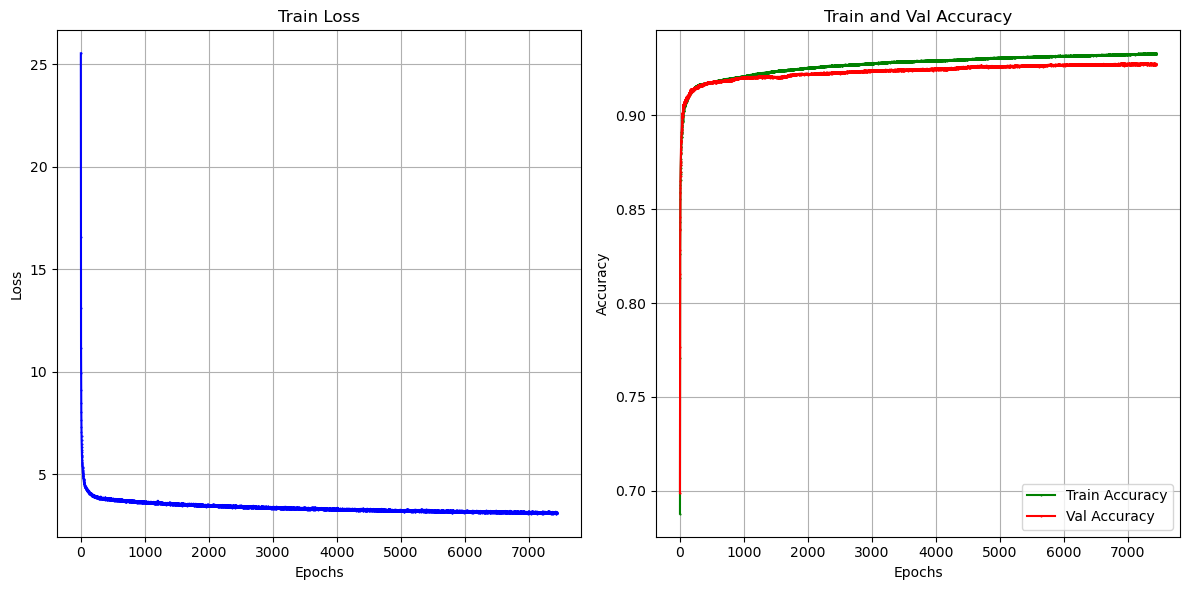

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', color='blue', marker='o', markersize=0.5)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_score, label='Train Accuracy', color='green', marker='o', markersize=0.5)
plt.plot(eval_score_ls, label='Val Accuracy', color='red', marker='o', markersize=0.5)
plt.title('Train and Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

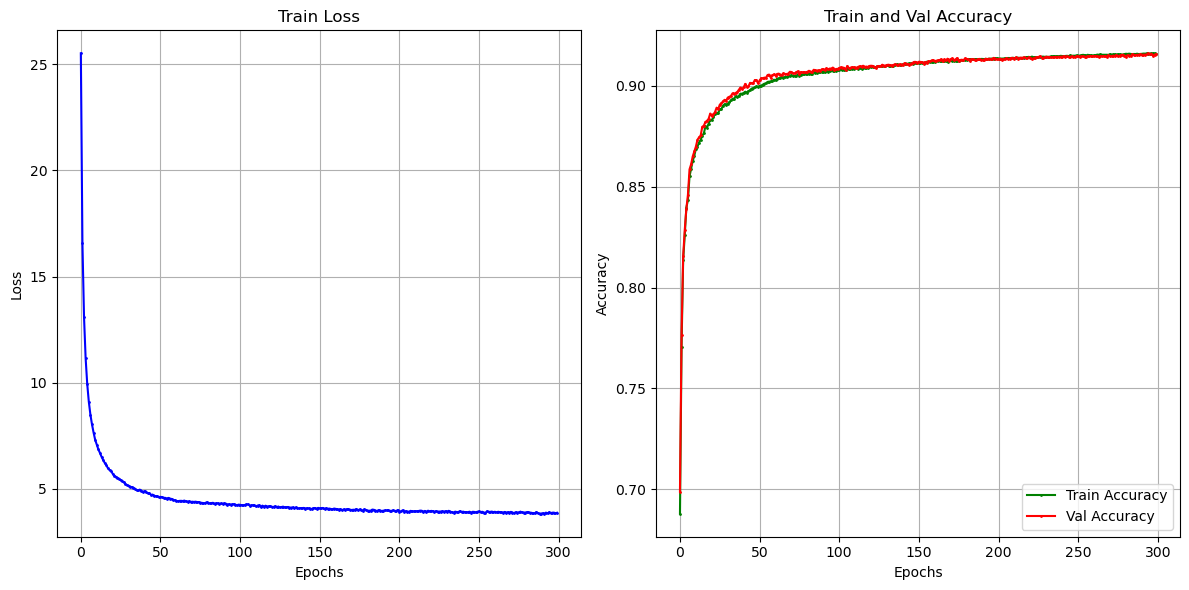

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss[:300], label='Train Loss', color='blue', marker='o', markersize=1)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_score[:300], label='Train Accuracy', color='green', marker='o', markersize=1)
plt.plot(eval_score_ls[:300], label='Val Accuracy', color='red', marker='o', markersize=1)
plt.title('Train and Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
with open('saved_models/training_data.pkl', 'wb') as f:
    pickle.dump({'train_loss': train_loss, 'train_score': train_score, 'eval_score_ls': eval_score_ls}, f)

In [ ]:
with open('saved_models/training_data.pkl', 'rb') as f:
    data = pickle.load(f)
train_loss = data['train_loss']
train_score = data['train_score']
eval_score_ls = data['eval_score_ls']